In [1]:
from kmod import gan_ume_opt as gt
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util
from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

import utils, torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [2]:
class generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, dataset='celebA'):
        
        super(generator, self).__init__()
        
        z_size=100
        out_size=3
        ngf=128
        
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: out_size x 64 x 64
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output
    def load(self,save_dir):
        self.load_state_dict(torch.load(save_dir))

In [3]:
!CUDA_VISIBLE_DEVICES=1,2
torch.backends.cudnn.enabled = True

In [4]:
data_dir = '../problems/celeba/img_align_celeba'
test_img_list = []
with open('../problems/celeba/test_list.txt') as f:
    for line in f:
        test_img_list.append(line.rstrip('\n'))

In [5]:
def open_images(paths, size=64, resize=False):
    img_data = []
    for path in paths:
        im = Image.open(path)
        if resize:
            im = im.resize((size, size))
        im = np.array(im)
        img_data.append(im)
    return np.array(img_data)

def normalize(images, mean, std):
    """normalize ndarray images of shape N x H x W x C"""
    return (images - mean) / std

## Experiments on noise space optimization (under construction)

In [6]:
import numpy
img_data = []
for filename in test_img_list:
    data_path = '{}/{}'.format(data_dir, filename)
    im = numpy.array(Image.open(data_path))
    img_data.append(im)
img_data = np.array(img_data) / 255. #maybe better to normalize differently for tests
img_data.shape

(30000, 64, 64, 3)

In [ ]:
batch_size = 1000 #number of images we want to generate
z_dim = 100 #dimention of noise, this is fixed to 100 so don't change
model_dir = '../problems/celeba/models/'
gpu_id = 2
gpu_mode = True
gt.set_gpu_mode(gpu_mode)
gt.set_gpu_id(gpu_id)
gp = generator().cuda(gpu_id)
gp.eval()
gq = generator().cuda(gpu_id)
gq.eval()
gp.load('{}/GAN_G_smile_unif.pkl'.format(model_dir))
gq.load('{}/GAN_G_nosmile_unif.pkl'.format(model_dir))

sample_z_ = Variable((torch.rand((batch_size, z_dim))).view(-1, z_dim, 1, 1))
sample_z_ = sample_z_.cuda(gpu_id)
sample_z_ = -2. * sample_z_ + 1.
sample_z_ = sample_z_.float()
samples_p_show = gp(sample_z_).cpu().data.numpy().transpose(0, 2, 3, 1)
samples_p = samples_p_show.reshape([samples_p_show.shape[0], -1])

sample_z_ = Variable((torch.rand((batch_size, z_dim))).view(-1, z_dim, 1, 1))
sample_z_ = sample_z_.cuda(gpu_id)
sample_z_ = -2. * sample_z_ + 1.
sample_z_ = sample_z_.float()
samples_q_show = gq(sample_z_).cpu().data.numpy().transpose(0, 2, 3, 1)
samples_q = samples_q_show.reshape([samples_q_show.shape[0], -1])

tr_data = img_data[:15000].reshape((15000, -1))
datap = data.Data(np.clip(samples_p, 0, 1))
dataq = data.Data(np.clip(samples_q, 0, 1))
datar = data.Data(tr_data[:batch_size])

In [ ]:


plt.figure(figsize=(8, 8))

grid_size = 5

for i in range(grid_size**2):

    img = np.clip(samples_p_show[i], 0, 1) 
    
    plt.subplot(grid_size, grid_size, i+1)    

    plt.imshow(img)

plt.axis('off')

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(grid_size**2):

    img = np.clip(samples_q_show[i], 0, 1) 
    
    plt.subplot(grid_size, grid_size, i+1)    

    plt.imshow(img)

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(grid_size**2):
    img = np.clip(img_data[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(img)

In [ ]:
J = 3
Zp0 = Zq0 = np.random.uniform(-1, 1, (J, z_dim))
XYZ = np.vstack((datap.data(), dataq.data(), datar.data()))
med2 = util.meddistance(XYZ, subsample=1000)**2

In [ ]:
with util.ContextTimer() as t:
    Z_opt, gw_opt, opt_result = gt.optimize_3sample_criterion(datap, dataq, datar, gp, gq, Zp0, Zq0, gwidth0=med2)

In [ ]:
print(t.secs / 60.)
zp_opt = Variable(torch.from_numpy(Z_opt[:J]).float().view(-1, z_dim, 1, 1)).cuda(gpu_id)
zq_opt = Variable(torch.from_numpy(Z_opt[J:]).float().view(-1, z_dim, 1, 1)).cuda(gpu_id)
sample_p_opt = gp(zp_opt).cpu().data.numpy().transpose(0, 2, 3, 1)
sample_q_opt = gq(zp_opt).cpu().data.numpy().transpose(0, 2, 3, 1)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(sample_p_opt.shape[0]):
    img = np.clip(sample_p_opt[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)    
    plt.imshow(img)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(sample_q_opt.shape[0]):
    img = np.clip(sample_q_opt[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)    
    plt.imshow(img)

## Experiments on discrete optimization

In [6]:
# loading data path
data_dir = '../problems/celeba/img_align_celeba'
test_img_list = []
with open('../problems/celeba/test_list.txt') as f:
    for line in f:
        test_img_list.append(line.rstrip('\n'))
smile_img_list = []
with open('../problems/celeba/test_smile.txt') as f:
    for line in f:
        smile_img_list.append(line.rstrip('\n'))
non_smile_img_list = [filename for filename in test_img_list 
                      if filename not in smile_img_list]

In [7]:
# loading image data
paths = ['{}/{}'.format(data_dir, filename) for filename in smile_img_list]
smile_img_data = open_images(paths, 224, resize=True)
smile_img_data = smile_img_data / 255
paths = ['{}/{}'.format(data_dir, filename) for filename in non_smile_img_list]
non_smile_img_data = open_images(paths, 224, resize=True)
non_smile_img_data = non_smile_img_data / 255
n1 = smile_img_data.shape[0]
n2 = non_smile_img_data.shape[0]
tr_data = np.vstack([smile_img_data[:int(n1/2)], non_smile_img_data[:int(n2/2)]])
te_data = np.vstack([smile_img_data[int(n1/2):], non_smile_img_data[int(n2/2):]])

In [8]:
# creating training and test data
mean = np.mean(tr_data, axis=(0, 1, 2))
std = np.std(tr_data, axis=(0, 1, 2))
print(mean, std)

[0.61771393 0.4566219  0.38276812] [0.25477521 0.22050872 0.21047819]


In [9]:
smile_img_data_norm = normalize(smile_img_data, mean, std)
smile_tr_data = smile_img_data_norm[:int(n1/2)]
smile_te_data = smile_img_data_norm[int(n1/2):]
non_smile_img_data_norm = normalize(non_smile_img_data, mean, std)
non_smile_tr_data = non_smile_img_data_norm[:int(n2/2)]
non_smile_te_data = non_smile_img_data_norm[int(n2/2):]

In [10]:
del(non_smile_img_data)
del(smile_img_data)

In [11]:
# loading a feature extractor 
import pretrainedmodels
model_name = 'resnet18'
model = pretrainedmodels.__dict__[model_name]().cuda(2)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [12]:
sample_size = 500
half_n1 = int(n1 / 2)
half_n2 = int(n2 / 2)

random_idx_p = np.random.permutation(half_n1)[:sample_size]
datap = smile_tr_data[random_idx_p].reshape(sample_size, -1)
datap = data.Data(datap)

random_idx_q = np.random.permutation(half_n2)[:sample_size]
dataq = non_smile_tr_data[random_idx_q].reshape(sample_size, -1)
dataq = data.Data(dataq)

rest_tr_data = np.vstack(
    [
     np.delete(smile_tr_data, random_idx_p, axis=0),
     np.delete(non_smile_tr_data, random_idx_q, axis=0)
    ]
)

n = rest_tr_data.shape[0]
random_idx_r = np.random.permutation(n)[:sample_size]
datar = rest_tr_data[random_idx_r].reshape(sample_size, -1)
datar = data.Data(datar)

del(rest_tr_data)

In [13]:
te_data_norm = normalize(te_data, mean, std)

In [14]:
num_candidates = 500
random_idx = np.random.permutation(half_n1 + half_n2)[:num_candidates]
locs = te_data_norm[random_idx]
#locs = smile_img_data_norm[-num_candidates:]
locs = locs.reshape((locs.shape[0], -1))
XYZ = np.vstack((datap.data(), dataq.data(), datar.data()))
med2 = util.meddistance(XYZ, subsample=1000)**2
J = 5

In [15]:
with util.ContextTimer() as t:
    p_best_locs = gt.opt_greedy_3sample_criterion(datap, dataq, datar,
                                                model.features, locs,
                                                med2, J, maximize=False)

In [16]:
with util.ContextTimer() as t:
    q_best_locs = gt.opt_greedy_3sample_criterion(datap, dataq, datar,
                                                model.features, locs,
                                                med2, J, maximize=True)

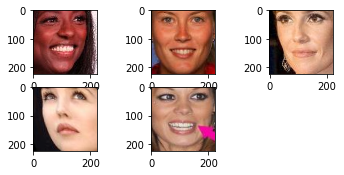

In [19]:
grid_size = 3
images = locs.reshape((num_candidates, 224, 224, 3)) * std + mean
for i in range(len(p_best_locs)):
    idx = p_best_locs[i]
    img = images[idx]
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(img)

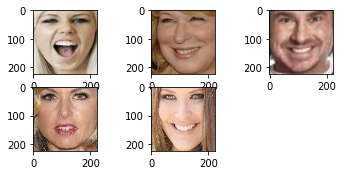

In [20]:
grid_size = 3
for i in range(len(q_best_locs)):
    idx = q_best_locs[i]
    img = images[idx]
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(img)